In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import networkx as nx

from qiskit import IBMQ,BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit,ClassicalRegister,QuantumRegister,execute

from qiskit.tools.visualization import plot_histogram

Many thanks to Dr. Shijie Wei, Dr. GuiLu Long and Dr. Zhou for their kindness in explaining and correcting my mistakes.

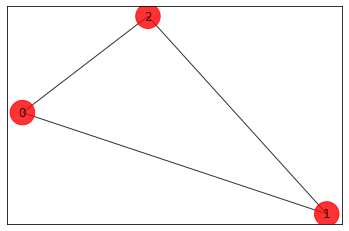

In [2]:
#Create the graph to be cut 

n=3 #nr nodes
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(2,1,1.0),(1,0,2.0),(2,0,7.0)]#list with conected  node and  coresponding weight(1,0,1.0)]
G.add_weighted_edges_from(elist)

colors=['r' for node in G.nodes()]
pos=nx.spring_layout(G)
default_axes=plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors,node_size=600,alpha=.8,ax=default_axes,pos=pos)


In [3]:
#compute the weight matrix

w=np.zeros([n,n])
for i in range (n):
    for j in range(n):
        temp=G.get_edge_data(i,j,default=0)
        if temp!=0:
            w[i,j]=temp['weight']
print(w)

[[0. 2. 7.]
 [2. 0. 1.]
 [7. 1. 0.]]


case=[0, 0, 0] cost= 0.0
case=[1, 0, 0] cost= 9.0
case=[0, 1, 0] cost= 3.0
case=[1, 1, 0] cost= 8.0
case=[0, 0, 1] cost= 8.0
case=[1, 0, 1] cost= 3.0
case=[0, 1, 1] cost= 9.0
case=[1, 1, 1] cost= 0.0

Best solution = [0, 1, 1] cost = 9.0


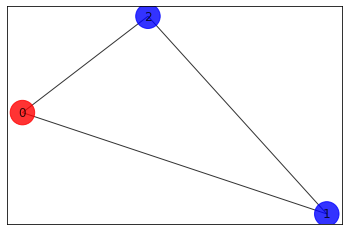

In [4]:
#brut force  for verification  :

best_cost_brute=0
for b in range(2**n):
    x=[int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost=0
    for i in range(n):
        for j in range(n):
            cost=cost+w[i,j]*x[i]*(1-x[j])
            
    if best_cost_brute<=cost:
        best_cost_brute=cost
        xbest_brute=x
            
    print('case='+str(x)+' cost=',str(cost))
    
colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))  

In [5]:
#compute Y,X 

sizeY=0
for i in range(n):
    sizeY=sizeY+i
    
sizeY=2**int(math.log(sizeY,2))*2  
print('sizeY='+str(sizeY))

sizeY=int(sizeY)
Y=np.zeros(sizeY)
print(Y)
y0=0.32
y=-2*y0

################################
Y[0] = 1  # the coefficent of I
################################

#####################
C=1 # modified
#####################
k=1 
for i in range (n):
    for j in range (i):
        ###########################
        Y[k]=w[i,j] * y # modified
        C=C+Y[k]*Y[k]
        ###########################
        k+=1
        #print(str(j)+' '+str(i)) #useful wey yo see conection betwen nodes for me 
print(Y)
C=math.sqrt(C)    
for i in range(sizeY):
    ###########################
    Y[i]=Y[i]/C     # modified
    ###########################

X=[1/math.sqrt(2**n) for i in range(2**n)]  

print(Y)
print(X)

sizeY=4
[0. 0. 0. 0.]
[ 1.   -1.28 -4.48 -0.64]
[ 0.20797978 -0.26621412 -0.93174941 -0.13310706]
[0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373]


# ccz gate

In [6]:
#create double control z matrices  with suplimentar  control on  classical register 
def cczc(self,c0,c1,t,cr):
    self.crz(np.pi/2,c1,t).c_if(cr,0)#1/2Z
    self.u1(np.pi/4,c1).c_if(cr,0)
    self.cx(c1,c0).c_if(cr,0)
    self.crz(-np.pi/2,c0,t).c_if(cr,0)#-1/2Z
    self.u1(-np.pi/4,c0).c_if(cr,0)
    self.cx(c1,c0).c_if(cr,0)
    self.crz(np.pi/2,c0,t).c_if(cr,0)#1/2cz
    self.u1(np.pi/4,c0).c_if(cr,0)

In [7]:
#creat  a double  control z matrices 
def ccz(self,c0,c1,t):
    self.crz(np.pi/2,c1,t)#1/2Z
    self.u1(np.pi/4,c1)
    self.cx(c1,c0)
    self.crz(-np.pi/2,c0,t)#-1/2Z
    self.u1(-np.pi/4,c0)
    self.cx(c1,c0)
    self.crz(np.pi/2,c0,t)#1/2cz
    self.u1(np.pi/4,c0)

In [8]:
# build circuit for  these particular exmple  

def Gcirc3(n,m,stateVectorY,stateVectorX):
    
    qx=QuantumRegister(n,'qx')
    cx=ClassicalRegister(n,'cx')
    
    qy1=QuantumRegister(m,'qy1')
    cy1=ClassicalRegister(m,'cy1')
    cy2=ClassicalRegister(m,'cy2')
    cy3=ClassicalRegister(m,'cy3')
    cy4=ClassicalRegister(m,'cy4')
    
    p=QuantumRegister(1,'p')# register use to setclassical register to 1  
    
    qc=QuantumCircuit(p, qy1,qx,cy1,cy2,cy3,cy4,cx) 
    
    #set classical regiter to 1  to avoid fake  0
    qc.x(p[0])
    for i in range(2):
        qc.measure(p[0], cy1[i])
        qc.measure(p[0], cy2[i])
        qc.measure(p[0], cy3[i])
        qc.measure(p[0], cy4[i])
    qc.barrier()
    
    ###############################################
    qc.initialize(stateVectorY,qy1)
    qc.initialize(stateVectorX,qx)
    qc.barrier()
    

    #01
    qc.x(qy1[1]) #we need to have state 01 to aply Z matrices 
    ccz(qc,qy1[0],qy1[1], qx[0])
    ccz(qc,qy1[0],qy1[1], qx[1])
    qc.x(qy1[1]) #put qy[1] in his initial state 

    #02
    qc.x(qy1[0])
    ccz(qc,qy1[0],qy1[1], qx[0])
    ccz(qc,qy1[0],qy1[1], qx[2])
    qc.x(qy1[0])
    
    #12
    ccz(qc,qy1[0],qy1[1], qx[1])
    ccz(qc,qy1[0],qy1[1], qx[2])
     
    qc.barrier()
    for i in range(m):
        qc.h(qy1[i])
     
    qc.barrier() 
    
    for i in range(m):
        qc.measure(qy1[i], cy1[i])
    qc.barrier()
    
    #############################################
    for i in range(m):   
        qc.reset(qy1[i]).c_if(cy1,0)
        
    qc.initialize(stateVectorY,qy1).c_if(cy1,0)  
    
    #01
    qc.x(qy1[1]).c_if(cy1,0) #we need to have state 01 to aply Z matrices 
    cczc(qc,qy1[0],qy1[1], qx[0],cy1)
    cczc(qc,qy1[0],qy1[1], qx[1],cy1)
    qc.x(qy1[1]).c_if(cy1,0) #put qy[1] in his initial state 

    #02
    qc.x(qy1[0]).c_if(cy1,0)
    cczc(qc,qy1[0],qy1[1], qx[0],cy1)
    cczc(qc,qy1[0],qy1[1], qx[2],cy1)
    qc.x(qy1[0]).c_if(cy1,0)

    #12
    cczc(qc,qy1[0],qy1[1], qx[1],cy1)
    cczc(qc,qy1[0],qy1[1], qx[2],cy1)
    
    qc.barrier()
    for i in range(m):
        qc.h(qy1[i]).c_if(cy2,0)
        
    qc.barrier()
    for i in range(m):
        qc.measure(qy1[i], cy2[i]).c_if(cy1,0)
    qc.barrier()  
    
    #############################################
    for i in range(m):   
        qc.reset(qy1[i]).c_if(cy1,0) 
        
    qc.initialize(stateVectorY,qy1).c_if(cy2,0)   
        
    #01
    qc.x(qy1[1]).c_if(cy2,0) #we need to have state 01 to aply Z matrices 
    cczc(qc,qy1[0],qy1[1], qx[0],cy2)
    cczc(qc,qy1[0],qy1[1], qx[1],cy2)
    qc.x(qy1[1]).c_if(cy2,0) #put qy[1] in his initial state 

    #02
    qc.x(qy1[0]).c_if(cy2,0)
    cczc(qc,qy1[0],qy1[1], qx[0],cy2)
    cczc(qc,qy1[0],qy1[1], qx[2],cy2)
    qc.x(qy1[0]).c_if(cy2,0)

    #12
    cczc(qc,qy1[0],qy1[1], qx[1],cy2)
    cczc(qc,qy1[0],qy1[1], qx[2],cy2)
    
         
    qc.barrier()
    for i in range(m):
        qc.h(qy1[i]).c_if(cy2,0)
    qc.barrier()
    for i in range(m):
        qc.measure(qy1[i], cy3[i]).c_if(cy2,0)
    qc.barrier()
    
    ###############################################
    for i in range(m):   
        qc.reset(qy1[i]).c_if(cy3,0) 
        
    qc.initialize(stateVectorY,qy1).c_if(cy3,0)   
        
    #01
    qc.x(qy1[1]).c_if(cy3,0) #we need to have state 01 to aply Z matrices 
    cczc(qc,qy1[0],qy1[1], qx[0],cy3)
    cczc(qc,qy1[0],qy1[1], qx[1],cy3)
    qc.x(qy1[1]).c_if(cy3,0) #put qy[1] in his initial state 

    #02
    qc.x(qy1[0]).c_if(cy3,0)
    cczc(qc,qy1[0],qy1[1], qx[0],cy3)
    cczc(qc,qy1[0],qy1[1], qx[2],cy3)
    qc.x(qy1[0]).c_if(cy3,0)

    #12
    cczc(qc,qy1[0],qy1[1], qx[1],cy3)
    cczc(qc,qy1[0],qy1[1], qx[2],cy3)
    
         
    qc.barrier()
    for i in range(m):
        qc.h(qy1[i]).c_if(cy3,0)
    qc.barrier()
    for i in range(m):
        qc.measure(qy1[i], cy4[i]).c_if(cy3,0)   
    qc.barrier()
    
    ###############################################    
    for i in range(m):   
        qc.reset(qy1[i]).c_if(cy4,0) 
        
    qc.initialize(stateVectorY,qy1).c_if(cy4,0)   
        
    #01
    qc.x(qy1[1]).c_if(cy4,0) #we need to have state 01 to aply Z matrices 
    cczc(qc,qy1[0],qy1[1], qx[0],cy4)
    cczc(qc,qy1[0],qy1[1], qx[1],cy4)
    qc.x(qy1[1]).c_if(cy4,0) #put qy[1] in his initial state 

    #02
    qc.x(qy1[0]).c_if(cy4,0)
    cczc(qc,qy1[0],qy1[1], qx[0],cy4)
    cczc(qc,qy1[0],qy1[1], qx[2],cy4)
    qc.x(qy1[0]).c_if(cy4,0)

    #12
    cczc(qc,qy1[0],qy1[1], qx[1],cy4)
    cczc(qc,qy1[0],qy1[1], qx[2],cy4)
    
         
    qc.barrier()
    for i in range(m):
        qc.h(qy1[i]).c_if(cy4,0)
    qc.barrier()
    for i in range(m):
        qc.measure(qy1[i], cy4[i]).c_if(cy4,0)
    qc.barrier()  
    
    ##############################################  
    qc.barrier()
    for i in range(n):
        qc.measure(qx[i], cx[i]).c_if(cy4,0)
        
        
    #qc.draw(output="mpl")
    return qc

qc=Gcirc3(3,2,Y,X)
qc.draw()

┌───┐┌─┐┌─┐┌─┐┌─┐┌─┐┌─┐┌─┐┌─┐ ░ »
  p_0: ┤ X ├┤M├┤M├┤M├┤M├┤M├┤M├┤M├┤M├─░─»
       └───┘└╥┘└╥┘└╥┘└╥┘└╥┘└╥┘└╥┘└╥┘ ░ »
qy1_0: ──────╫──╫──╫──╫──╫──╫──╫──╫──░─»
             ║  ║  ║  ║  ║  ║  ║  ║  ░ »
qy1_1: ──────╫──╫──╫──╫──╫──╫──╫──╫──░─»
             ║  ║  ║  ║  ║  ║  ║  ║  ░ »
 qx_0: ──────╫──╫──╫──╫──╫──╫──╫──╫──░─»
             ║  ║  ║  ║  ║  ║  ║  ║  ░ »
 qx_1: ──────╫──╫──╫──╫──╫──╫──╫──╫──░─»
             ║  ║  ║  ║  ║  ║  ║  ║  ░ »
 qx_2: ──────╫──╫──╫──╫──╫──╫──╫──╫──░─»
             ║  ║  ║  ║  ║  ║  ║  ║  ░ »
cy1_0: ══════╩══╬══╬══╬══╬══╬══╬══╬════»
                ║  ║  ║  ║  ║  ║  ║    »
cy1_1: ═════════╬══╬══╬══╩══╬══╬══╬════»
                ║  ║  ║     ║  ║  ║    »
cy2_0: ═════════╩══╬══╬═════╬══╬══╬════»
                   ║  ║     ║  ║  ║    »
cy2_1: ════════════╬══╬═════╩══╬══╬════»
                   ║  ║        ║  ║    »
cy3_0: ════════════╩══╬════════╬══╬════»
                      ║        ║  ║    »
cy3_1: ═══════════════╬════════╩══╬════»
                      ║           ║    »
cy4_0: ═══════════════╩═══════════╬════»
                                  ║    »
cy4_1: ═══════════════════════════╩════»
                                       »
 cx_0: ════════════════════════════════»
                                       »
 cx_1: ════════════════════════════════»
                                       »
 cx_2: ════════════════════════════════»
                                       »
«                                                                                       »
«  p_0: ────────────────────────────────────────────────────────────────────────────────»
«                     ┌─────────────────────────────────────────────────┐               »
«qy1_0: ──────────────┤0                                                ├───────────────»
«                     │  initialize(0.20798,-0.26621,-0.93175,-0.13311) │               »
«qy1_1: ──────────────┤1                                                ├───────────────»
«       ┌─────────────┴─────────────────────────────────────────────────┴──────────────┐»
« qx_0: ┤0                                                                             ├»
«       │                                                                              │»
« qx_1: ┤1 initialize(0.35355,0.35355,0.35355,0.35355,0.35355,0.35355,0.35355,0.35355) ├»
«       │                                                                              │»
« qx_2: ┤2                                                                             ├»
«       └──────────────────────────────────────────────────────────────────────────────┘»
«cy1_0: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy1_1: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy2_0: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy2_1: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy3_0: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy3_1: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy4_0: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy4_1: ════════════════════════════════════════════════════════════════════════════════»
«                                                   

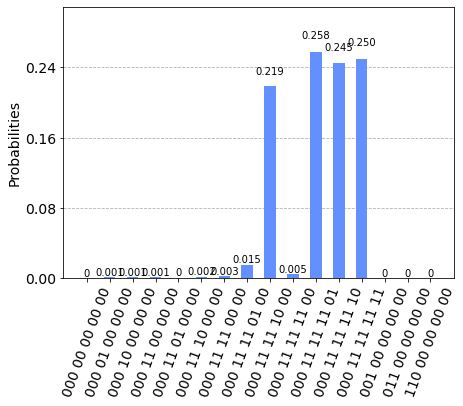

In [10]:
qc=Gcirc3(3,2,Y,X)
backend = BasicAer.get_backend('qasm_simulator')
shot = 9000#00
results= execute(qc,backend=backend,shots=shot).result()
counts=results.get_counts(qc)
plot_histogram(counts)

In [11]:
print(counts)

{'011 00 00 00 00': 1, '000 11 11 11 00': 41, '000 11 01 00 00': 8, '110 00 00 00 00': 2, '000 10 00 00 00': 9, '000 11 11 11 10': 2201, '000 11 11 10 00': 1971, '000 00 00 00 00': 1, '000 11 10 00 00': 17, '000 11 11 01 00': 138, '001 00 00 00 00': 1, '000 11 11 11 11': 2249, '000 11 11 11 01': 2318, '000 01 00 00 00': 9, '000 11 11 00 00': 23, '000 11 00 00 00': 11}


In [12]:
dc={'000':0 ,'001':0 ,'010':0 ,'011':0 ,'100':0 ,'101':0 ,'110':0 ,'111':0 ,}
if '000 00 00 00 00' in counts:
    print('000:'+str(counts['000 00 00 00 00']))
    dc['000']=counts['000 00 00 00 00']
else :
    print("nu")
if '001 00 00 00 00' in counts:
    print('001:'+str(counts['001 00 00 00 00']))
    dc['001']=counts['001 00 00 00 00']
else :
    print("nu")
if '010 00 00 00 00' in counts:
    print('010:'+str(counts['010 00 00 00 00'])) 
    dc['010']=counts['010 00 00 00 00']
else :
    print("nu")
if '011 00 00 00 00' in counts:
    print('011:'+str(counts['011 00 00 00 00']))
    dc['011']=counts['011 00 00 00 00']
else :
    print("nu")
if '101 00 00 00 00' in counts:
    print('101:'+str(counts['101 00 00 00 00']))
    dc['101']=counts['101 00 00 00 00']
else :
    print("nu")
if '110 00 00 00 00' in counts:
    print('110:'+str(counts['110 00 00 00 00']))
    dc['110']=counts['110 00 00 00 00']
else :
    print("nu")
if '111 00 00 00 00' in counts:
    print('111:'+str(counts['111 00 00 00 00']))
    dc['111']=counts['111 00 00 00 00']
else :
    print("nu")

000:1
001:1
nu
011:1
nu
110:2
nu


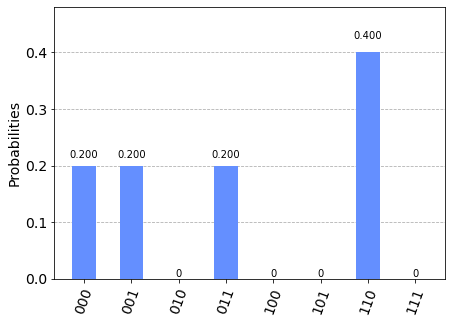

In [13]:
plot_histogram(dc)

In [14]:
overlap={'000':0,'001':0,'010':0,'100':0}
overlap['000']=dc['000']+dc['111']
overlap['001']=dc['001']+dc['110']
overlap['010']=dc['010']+dc['101']
overlap['100']=dc['100']+dc['001']

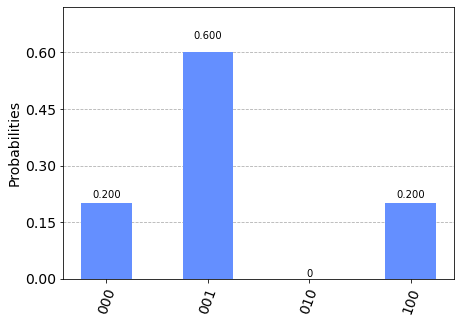

In [15]:
plot_histogram(overlap)

In [16]:
from qiskit.tools.monitor import job_monitor

In [17]:
IBMQ.save_account( '')

configrc.store_credentials:WARNING:2020-06-11 23:09:36,031: Credentials already present. Set overwrite=True to overwrite.


In [ ]:
#At this time you cannot perform post-measurement operations on a real QC as a need to use more qbits and error is a huge problem so answord is nut good .


In [18]:
provider = IBMQ.load_account()

In [48]:
def Gcirc3R(n,m,stateVectorY,stateVectorX):
    
    qx=QuantumRegister(n,'qx')
    cx=ClassicalRegister(n,'cx')
    
    qy1=QuantumRegister(m,'qy1')
    qy2=QuantumRegister(m,'qy2')
    qy3=QuantumRegister(m,'qy3')
    qy4=QuantumRegister(m,'qy4')
    cy1=ClassicalRegister(m,'cy1')
    cy2=ClassicalRegister(m,'cy2')
    cy3=ClassicalRegister(m,'cy3')
    cy4=ClassicalRegister(m,'cy4')
    
    qc=QuantumCircuit( qy1,qy2,qy3,qy4,qx,cy1,cy2,cy3,cy4,cx) 
    
    
    ###############################################
    qc.initialize(stateVectorY,qy1)
    qc.initialize(stateVectorY,qy2)
    qc.initialize(stateVectorY,qy3)
    qc.initialize(stateVectorY,qy4)
    qc.initialize(stateVectorX,qx)
    qc.barrier()
    

    #01
    qc.x(qy1[1]) #we need to have state 01 to aply Z matrices 
    ccz(qc,qy1[0],qy1[1], qx[0])
    ccz(qc,qy1[0],qy1[1], qx[1])
    qc.x(qy1[1]) #put qy[1] in his initial state 

    #02
    qc.x(qy1[0])
    ccz(qc,qy1[0],qy1[1], qx[0])
    ccz(qc,qy1[0],qy1[1], qx[2])
    qc.x(qy1[0])
    
    #12
    ccz(qc,qy1[0],qy1[1], qx[1])
    ccz(qc,qy1[0],qy1[1], qx[2])
     
    qc.barrier()
    for i in range(m):
        qc.h(qy1[i])
     
    qc.barrier() 
    #####################################################
    #01
    qc.x(qy2[1]) #we need to have state 01 to aply Z matrices 
    ccz(qc,qy2[0],qy2[1], qx[0])
    ccz(qc,qy2[0],qy2[1], qx[1])
    qc.x(qy2[1]) #put qy[1] in his initial state 

    #02
    qc.x(qy2[0])
    ccz(qc,qy2[0],qy2[1], qx[0])
    ccz(qc,qy2[0],qy2[1], qx[2])
    qc.x(qy2[0])
    
    #12
    ccz(qc,qy2[0],qy2[1], qx[1])
    ccz(qc,qy2[0],qy2[1], qx[2])
     
    qc.barrier()
    for i in range(m):
        qc.h(qy2[i])
    ##############################
    #01
    qc.x(qy3[1]) #we need to have state 01 to aply Z matrices 
    ccz(qc,qy3[0],qy3[1], qx[0])
    ccz(qc,qy3[0],qy3[1], qx[1])
    qc.x(qy3[1]) #put qy[1] in his initial state 

    #02
    qc.x(qy3[0])
    ccz(qc,qy3[0],qy3[1], qx[0])
    ccz(qc,qy3[0],qy3[1], qx[2])
    qc.x(qy2[0])
    
    #12
    ccz(qc,qy3[0],qy3[1], qx[1])
    ccz(qc,qy3[0],qy3[1], qx[2])
     
    qc.barrier()
    for i in range(m):
        qc.h(qy3[i])
    ##############################
        #01
    qc.x(qy4[1]) #we need to have state 01 to aply Z matrices 
    ccz(qc,qy4[0],qy4[1], qx[0])
    ccz(qc,qy4[0],qy4[1], qx[1])
    qc.x(qy4[1]) #put qy[1] in his initial state 

    #02
    qc.x(qy4[0])
    ccz(qc,qy4[0],qy4[1], qx[0])
    ccz(qc,qy4[0],qy4[1], qx[2])
    qc.x(qy2[0])
    
    #12
    ccz(qc,qy4[0],qy4[1], qx[1])
    ccz(qc,qy4[0],qy4[1], qx[2])
     
    qc.barrier()
    for i in range(m):
        qc.h(qy4[i])
    #############################
    for i in range(m):
        qc.measure(qy1[i], cy1[i])
        qc.measure(qy2[i], cy2[i])
        qc.measure(qy3[i], cy3[i])
        qc.measure(qy4[i], cy4[i])
    for i in range(n):
        qc.measure(qx[i], cx[i])

    return qc

qc2=Gcirc3R(3,2,Y,X)
#qc2.draw(output="mpl")
qc2.draw()

»
qy1_0: »
       »
qy1_1: »
       »
qy2_0: »
       »
qy2_1: »
       »
qy3_0: »
       »
qy3_1: »
       »
qy4_0: »
       »
qy4_1: »
       »
 qx_0: »
       »
 qx_1: »
       »
 qx_2: »
       »
cy1_0: »
       »
cy1_1: »
       »
cy2_0: »
       »
cy2_1: »
       »
cy3_0: »
       »
cy3_1: »
       »
cy4_0: »
       »
cy4_1: »
       »
 cx_0: »
       »
 cx_1: »
       »
 cx_2: »
       »
«                     ┌─────────────────────────────────────────────────┐               »
«qy1_0: ──────────────┤0                                                ├───────────────»
«                     │  initialize(0.20798,-0.26621,-0.93175,-0.13311) │               »
«qy1_1: ──────────────┤1                                                ├───────────────»
«                     ├─────────────────────────────────────────────────┤               »
«qy2_0: ──────────────┤0                                                ├───────────────»
«                     │  initialize(0.20798,-0.26621,-0.93175,-0.13311) │               »
«qy2_1: ──────────────┤1                                                ├───────────────»
«                     ├─────────────────────────────────────────────────┤               »
«qy3_0: ──────────────┤0                                                ├───────────────»
«                     │  initialize(0.20798,-0.26621,-0.93175,-0.13311) │               »
«qy3_1: ──────────────┤1                                                ├───────────────»
«                     ├─────────────────────────────────────────────────┤               »
«qy4_0: ──────────────┤0                                                ├───────────────»
«                     │  initialize(0.20798,-0.26621,-0.93175,-0.13311) │               »
«qy4_1: ──────────────┤1                                                ├───────────────»
«       ┌─────────────┴─────────────────────────────────────────────────┴──────────────┐»
« qx_0: ┤0                                                                             ├»
«       │                                                                              │»
« qx_1: ┤1 initialize(0.35355,0.35355,0.35355,0.35355,0.35355,0.35355,0.35355,0.35355) ├»
«       │                                                                              │»
« qx_2: ┤2                                                                             ├»
«       └──────────────────────────────────────────────────────────────────────────────┘»
«cy1_0: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy1_1: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy2_0: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy2_1: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy3_0: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy3_1: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy4_0: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
«cy4_1: ════════════════════════════════════════════════════════════════════════════════»
«                                                                                       »
« cx_0: ════════════════════════════════════════════════════════════════════════════════»
« 

In [49]:
#real device
IBMQ.get_provider(hub='ibm-q')
backend=provider.get_backend('ibmq_16_melbourne')
shots=8000
job_exp=execute(qc2,backend,shots=shots)
job_monitor(job_exp,interval=7)

Job Status: job has successfully run


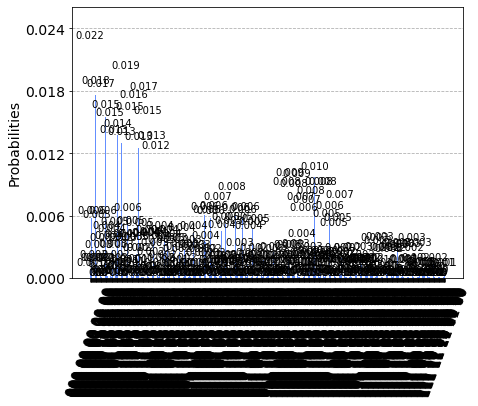

In [50]:
results=job_exp.result()
counts=results.get_counts()
plot_histogram(counts)

In [51]:
print(counts)

{'110 11 01 11 00': 2, '000 00 10 11 00': 5, '011 10 10 10 00': 3, '010 00 01 01 01': 1, '001 01 00 10 10': 1, '100 11 10 11 00': 3, '101 01 01 01 00': 3, '111 10 00 11 00': 1, '110 10 01 00 01': 1, '000 00 00 10 10': 3, '001 10 00 01 00': 12, '011 00 10 00 10': 1, '010 00 10 00 00': 46, '100 00 01 00 00': 74, '010 01 01 01 10': 1, '010 01 10 00 00': 42, '001 01 11 00 00': 20, '000 11 11 01 00': 28, '011 00 01 00 00': 13, '000 10 11 01 01': 1, '000 00 10 10 00': 26, '100 11 00 01 00': 17, '111 00 10 00 10': 1, '100 11 00 00 01': 1, '101 11 00 01 00': 4, '010 00 01 00 00': 47, '010 01 00 00 10': 4, '010 00 11 10 10': 1, '010 11 11 10 00': 4, '100 10 10 10 00': 15, '101 11 00 00 01': 2, '111 10 10 00 00': 5, '000 00 01 11 00': 12, '001 11 00 00 10': 1, '111 00 01 00 00': 9, '101 00 00 10 00': 5, '101 00 00 00 00': 11, '110 10 01 10 00': 3, '100 11 01 01 00': 13, '101 11 00 01 10': 1, '100 00 11 10 10': 1, '101 11 00 00 00': 12, '110 11 01 10 00': 5, '000 00 01 00 00': 141, '001 00 11 00 

In [52]:
dc2={'000':0 ,'001':0 ,'010':0 ,'011':0 ,'100':0 ,'101':0 ,'110':0 ,'111':0 ,}
if '000 00 00 00 00' in counts:
    print('000:'+str(counts['000 00 00 00 00']))
    dc2['000']=counts['000 00 00 00 00']
else :
    print("nu")
if '001 00  00 00 00' in counts:
    print('001:'+str(counts['001 00 00 00 00']))
    dc2['001']=counts['001 00 00 00 00']
else :
    print("nu")
if '010 00 00 00 00' in counts:
    print('010:'+str(counts['010 00 00 00 00'])) 
    dc2['010']=counts['010 00 00 00 00']
else :
    print("nu")
if '011 00 00 00 00' in counts:
    print('011:'+str(counts['011 00 00 00 00']))
    dc2['011']=counts['011 00 00 00 00']
else :
    print("nu")
if '101 00 00 00 00' in counts:
    print('101:'+str(counts['101 00 00 00 00']))
    dc2['101']=counts['101 00 00 00 00']
else :
    print("nu")
if '110 00 00 00 00' in counts:
    print('110:'+str(counts['110 00 00 00 00']))
    dc2['110']=counts['110 00 00 00 00']
else :
    print("nu")
if '111 00 00 00 00' in counts:
    print('111:'+str(counts['111 00 00 00 00']))
    dc2['111']=counts['111 00 00 00 00']
else :
    print("nu")

000:174
nu
010:49
011:9
101:11
110:26
111:9


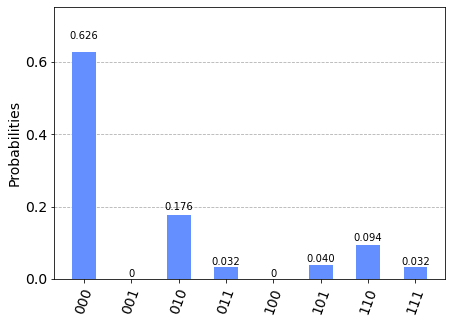

In [53]:
plot_histogram(dc2)

In [54]:
overlap={'000':0,'001':0,'010':0,'100':0}
overlap['000']=dc2['000']+dc2['111']
overlap['001']=dc2['001']+dc2['110']
overlap['010']=dc2['010']+dc2['101']
overlap['100']=dc2['100']+dc2['001']

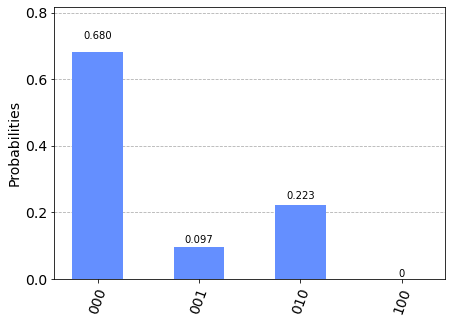

In [55]:
plot_histogram(overlap)

In [27]:
job_exp.error_message()